In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
# class sklearn.model_selection.StratifiedKFold(n_splits=5,
#     shuffle=False, random_state=None)
from typing import Union, Tuple
import warnings
warnings.simplefilter('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/data_for_revise/prediction/menu_ratio_and_review_points/データセット完成目的変数全て入っている.csv')
df

,県,エリア,サロン名,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,口コミスコアサロン全平均,雰囲気の全平均,接客サービスの全平均,技術・仕上がりの全平均,メニュー。料金の全平均,カラー比率,トリートメント比率,パーマ比率,縮毛矯正比率
0,島根,松江,Rote【ロテ】,18,237,179,7,24,41,48,5.0,0.983,4.65,4.7,4.7,4.7,4.3,0.556,0.112,0.034,0.045
1,島根,松江,freedom belinda 松江学園店 【フリーダム ベリンダ】,10,15,161,8,34,42,5,NaN,0.130,4.51,4.5,4.7,4.6,4.7,0.422,0.093,0.056,0.193
2,島根,松江,SMITH AVEDA,10,97,209,5,15,24,23,NaN,0.981,4.61,4.8,4.6,4.7,4.3,0.721,0.716,0.072,0.125
3,島根,松江,freedom rita【フリーダム リタ】,4,0,63,3,29,37,0,NaN,0.000,4.71,4.6,4.7,4.7,4.7,0.419,0.258,0.048,0.145
4,島根,松江,lamiell matsue 【ラミールマツエ】,8,104,340,8,30,26,44,NaN,0.767,4.52,4.6,4.6,4.5,4.3,0.472,0.327,0.009,0.127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4076,福山・尾道,福山駅前・三吉周辺,Chill hair,1,0,50,1,0,16,0,NaN,0.000,4.92,4.7,4.8,4.9,4.9,0.460,0.100,0.000,0.000
4077,福山・尾道,福山駅前・三吉周辺,SOYU headspa by Palm 【ソユ】,2,0,33,2,0,23,0,NaN,0.970,4.93,4.9,4.9,4.9,4.8,0.000,0.030,0.000,0.000
4078,福山・尾道,福山駅前・三吉周辺,Triangle,4,0,3,1,0,43,0,NaN,1.000,4.50,4.5,5.0,5.0,4.5,0.000,0.000,0.500,0.000
4079,福山・尾道,福山駅前・三吉周辺,Calin【カラン】,1,0,43,1,0,12,0,NaN,0.721,4.69,4.6,4.7,4.6,4.4,0.326,0.093,0.047,0.093


In [3]:
# df_X = df.iloc[:, :-1]
# df_y = df.iloc[:, -1]
# df_X[['県','エリア']]=df_X[['県','エリア']].astype('category')

In [4]:
class ContinuousStratifiedKFold:
    def __init__(self, n_split: int=5, shuffle: bool=True, random_state: int=42) -> None:
        self.n_split = n_split
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X: pd.DataFrame, reference: pd.Series, bins: int=10,
                      suffle: Union[bool]=None, random_state: Union[int]=None) -> Tuple[np.ndarray, np.ndarray]:

        shuffle = shuffle if suffle is not None else self.shuffle
        random_state = random_state if random_state is not None else self.random_state
        min_ref, max_ref = int(reference.min() - 1), int(reference.max() + 1)
        cut_threshold = np.linspace(min_ref, max_ref, bins)
        out = pd.cut(reference, bins=cut_threshold, labels=False)

        skf = StratifiedKFold(self.n_split, shuffle=shuffle, random_state=random_state)
        for train_idx, val_idx in skf.split(X, out):
            yield train_idx, val_idx

# 口コミスコアサロン全平均のモデル作成

In [43]:
prediction_column = '口コミスコアサロン全平均'

In [44]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,口コミスコアサロン全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.65
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.51
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.61
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.71
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.52
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.92
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.93
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,4.50
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.69


In [45]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [47]:
(_df_y==0).sum()

0

In [17]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [19]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

1it [00:00,  5.90it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.263552
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.257409
Training until validation scores don't improve for 10 rounds


5it [00:00, 13.42it/s]

Early stopping, best iteration is:
[7]	valid_0's rmse: 0.264963
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.274069
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.28493


In [20]:
scores

[0.26355186130488656,
 0.2574088153550129,
 0.2649634932845005,
 0.27406866254449347,
 0.28492989830049537]

In [21]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [24]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.263552,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.257409,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.264963,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.274069,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.284930,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


1.0 5.0 4.0


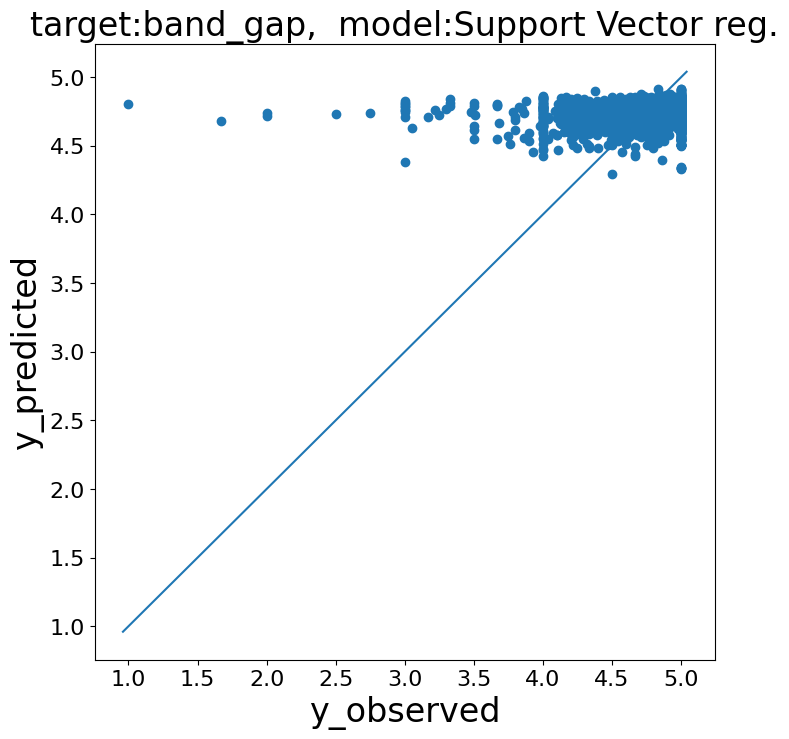

決定係数：0.049
RMSE：0.27


In [25]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [27]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,口コミスコアサロン全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.65
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.51
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.61
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.71
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.52
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.92
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.93
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,4.50
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.69


In [64]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

11    5.0
Name: 口コミスコアサロン全平均, dtype: float64

In [65]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [66]:
print(round(_score, 2), float(tmp_df_y))

4.84 5.0


In [68]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/general_review_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 接客サービスの全平均のモデル作成

In [52]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', '口コミスコアサロン全平均', '雰囲気の全平均',
       '接客サービスの全平均', '技術・仕上がりの全平均', 'メニュー。料金の全平均', 'カラー比率', 'トリートメント比率',
       'パーマ比率', '縮毛矯正比率'],
      dtype='object')

In [53]:
prediction_column = '接客サービスの全平均'

In [54]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,接客サービスの全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.7
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.7
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.6
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.7
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.8
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.9
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,5.0
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.7


In [55]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [56]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [57]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

2it [00:00, 14.39it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.244954
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.234201
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.248155
Training until validation scores don't improve for 10 rounds


5it [00:00, 14.87it/s]

Early stopping, best iteration is:
[13]	valid_0's rmse: 0.244024
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.253137


In [58]:
scores

[0.24495381050211967,
 0.23420124572560982,
 0.24815518599928965,
 0.24402439361189715,
 0.25313658094560976]

In [59]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [60]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.244954,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.234201,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.248155,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.244024,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.253137,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


1.8 5.0 3.2


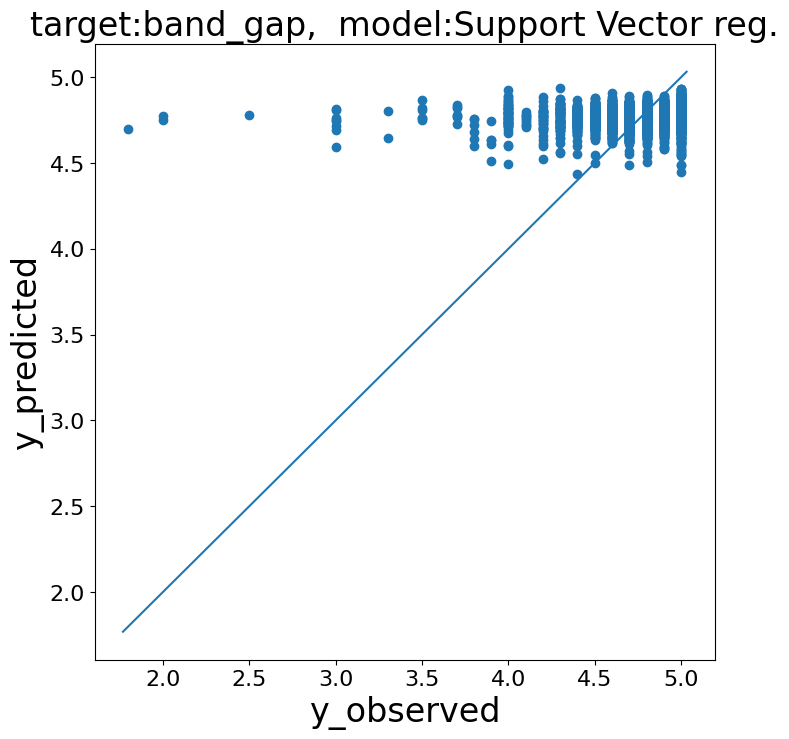

決定係数：0.045
RMSE：0.24


In [61]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [62]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,接客サービスの全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.7
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.7
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.6
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.7
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.8
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.9
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,5.0
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.7


In [66]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

2075    4.9
Name: 接客サービスの全平均, dtype: float64

In [67]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [68]:
print(round(_score, 2), float(tmp_df_y))

4.72 4.9


In [69]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 技術・仕上がりの全平均のモデル作成

In [88]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', '口コミスコアサロン全平均', '雰囲気の全平均',
       '接客サービスの全平均', '技術・仕上がりの全平均', 'メニュー。料金の全平均', 'カラー比率', 'トリートメント比率',
       'パーマ比率', '縮毛矯正比率'],
      dtype='object')

In [89]:
prediction_column = '技術・仕上がりの全平均'

In [90]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,技術・仕上がりの全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.7
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.6
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.7
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.7
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.9
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.9
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,5.0
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.6


In [91]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [92]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [93]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

2it [00:00, 15.59it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.289922
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.268364
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.280591
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.269008
Training until validation scores don't improve for 10 rounds


5it [00:00, 18.07it/s]

Early stopping, best iteration is:
[11]	valid_0's rmse: 0.266883


In [94]:
scores

[0.28992156061017615,
 0.268364025594603,
 0.2805904875130763,
 0.26900776341529353,
 0.2668833879263394]

In [95]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [96]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.289922,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.268364,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.280590,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.269008,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.266883,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


1.0 5.0 4.0


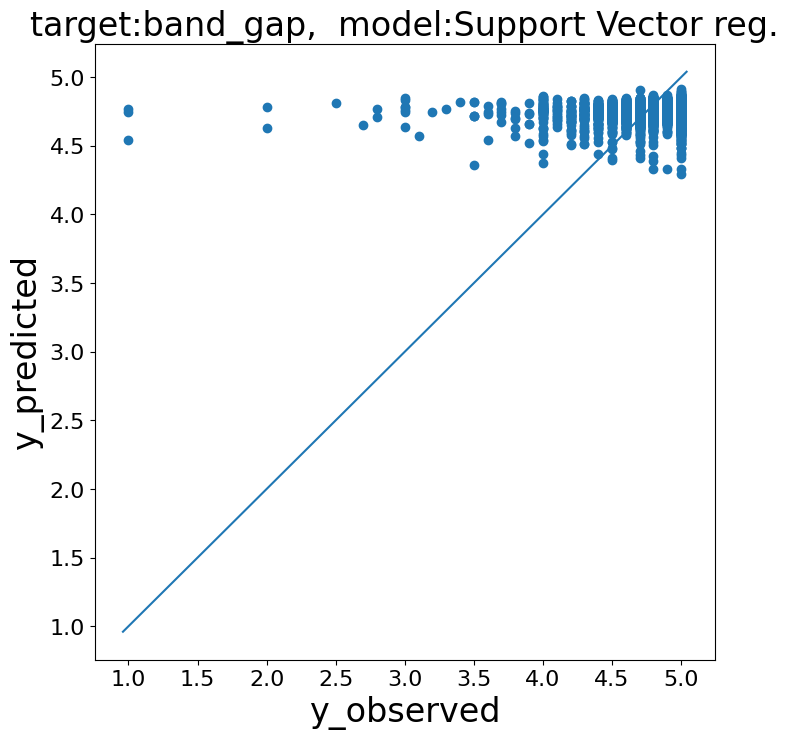

決定係数：0.036
RMSE：0.28


In [97]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [98]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,技術・仕上がりの全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.7
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.6
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.7
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.7
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.9
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.9
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,5.0
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.6


In [99]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

2199    5.0
Name: 技術・仕上がりの全平均, dtype: float64

In [100]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [101]:
print(round(_score, 2), float(tmp_df_y))

4.81 5.0


In [102]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# メニュー。料金の全平均のモデル作成

In [105]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', '口コミスコアサロン全平均', '雰囲気の全平均',
       '接客サービスの全平均', '技術・仕上がりの全平均', 'メニュー。料金の全平均', 'カラー比率', 'トリートメント比率',
       'パーマ比率', '縮毛矯正比率'],
      dtype='object')

In [106]:
prediction_column = 'メニュー。料金の全平均'

In [107]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,メニュー。料金の全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.3
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.7
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.3
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.7
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.9
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.8
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,4.5
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.4


In [108]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [109]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [110]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

2it [00:00, 16.62it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.305447
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 0.284508
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.285908
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.289806


5it [00:00, 16.48it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 0.299718


In [111]:
scores

[0.30544710051762086,
 0.2845082097717106,
 0.28590832625877266,
 0.28980591640357833,
 0.29971786816649054]

In [112]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [113]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.305447,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.284508,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.285908,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.289806,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.299718,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


2.0 5.0 3.0


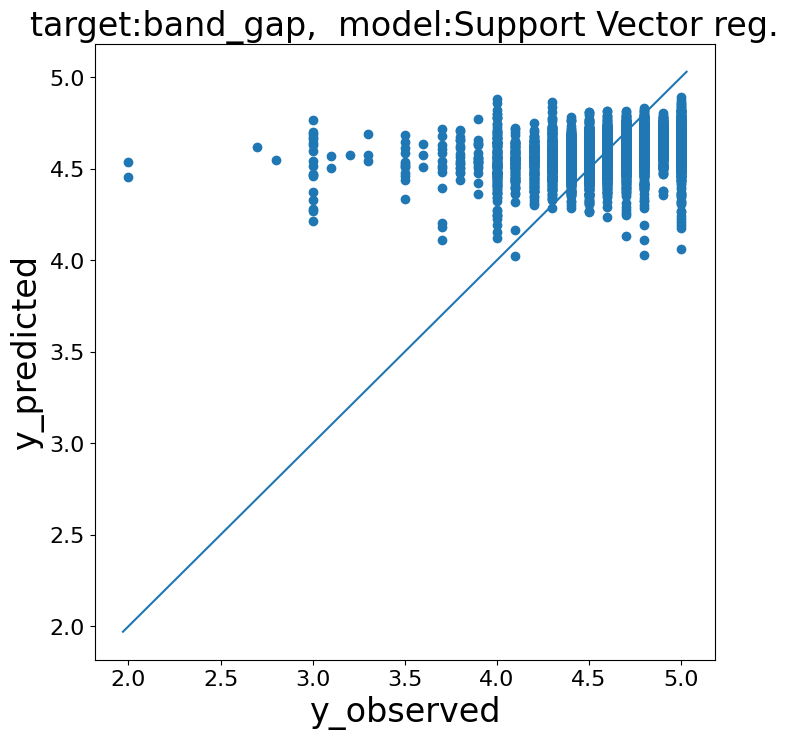

決定係数：0.081
RMSE：0.29


In [114]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [115]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,メニュー。料金の全平均
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,4.3
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,4.7
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,4.3
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,4.7
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...
3986,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,4.9
3987,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,4.8
3988,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,4.5
3989,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,4.4


In [116]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

3193    4.7
Name: メニュー。料金の全平均, dtype: float64

In [117]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [118]:
print(round(_score, 2), float(tmp_df_y))

4.75 4.7


In [119]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 'カラー比率'のモデル作成

In [120]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', '口コミスコアサロン全平均', '雰囲気の全平均',
       '接客サービスの全平均', '技術・仕上がりの全平均', 'メニュー。料金の全平均', 'カラー比率', 'トリートメント比率',
       'パーマ比率', '縮毛矯正比率'],
      dtype='object')

In [121]:
prediction_column = 'カラー比率'

In [130]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
_df=_df[_df[prediction_column]!=1.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,カラー比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.556
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.422
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.721
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.419
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.472
...,...,...,...,...,...,...,...,...,...,...,...,...
3672,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.707
3673,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.292
3674,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0.460
3675,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0.326


In [131]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [132]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [133]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

2it [00:00, 15.41it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.177916
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.174983
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.179472
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.178983
Training until validation scores don't improve for 10 rounds


5it [00:00, 17.77it/s]

Early stopping, best iteration is:
[12]	valid_0's rmse: 0.173822


In [134]:
scores

[0.17791588504421565,
 0.17498267343953613,
 0.17947219032601194,
 0.17898297639946603,
 0.17382231823799313]

In [135]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [136]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.177916,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.174983,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.179472,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.178983,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.173822,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


0.01 0.996 0.986


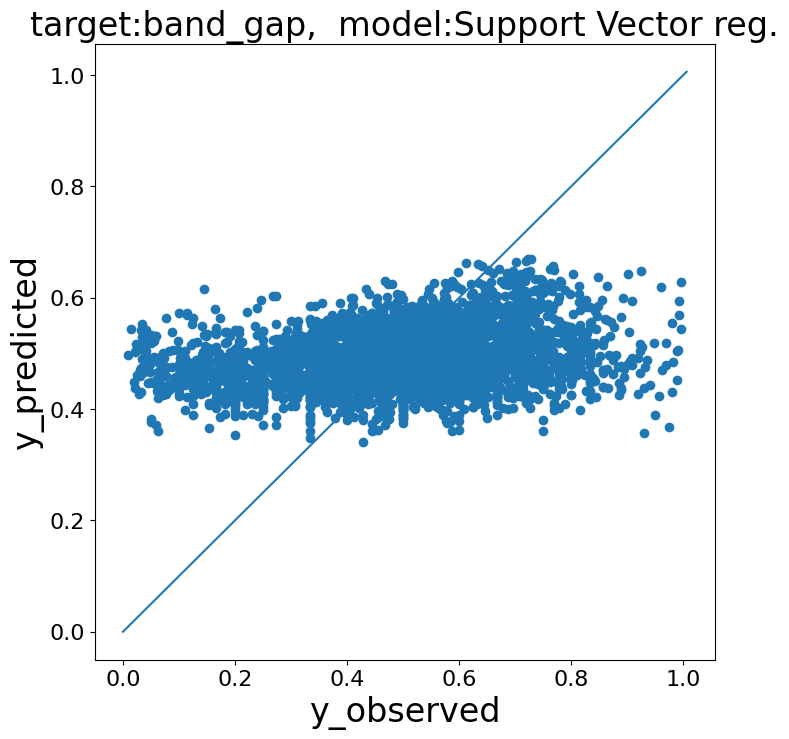

決定係数：0.082
RMSE：0.18


In [137]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [138]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,カラー比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.556
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.422
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.721
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.419
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.472
...,...,...,...,...,...,...,...,...,...,...,...,...
3672,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.707
3673,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.292
3674,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0.460
3675,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0.326


In [169]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

1749    0.828
Name: カラー比率, dtype: float64

In [170]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [171]:
print(round(_score, 2), float(tmp_df_y))

0.55 0.828


In [172]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 'トリートメント比率'のモデル作成

In [173]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', '口コミスコアサロン全平均', '雰囲気の全平均',
       '接客サービスの全平均', '技術・仕上がりの全平均', 'メニュー。料金の全平均', 'カラー比率', 'トリートメント比率',
       'パーマ比率', '縮毛矯正比率'],
      dtype='object')

In [174]:
prediction_column = 'トリートメント比率'

In [175]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
_df=_df[_df[prediction_column]!=1.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,トリートメント比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.112
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.093
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.716
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.258
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.327
...,...,...,...,...,...,...,...,...,...,...,...,...
3390,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.439
3391,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.153
3392,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0.100
3393,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0.030


In [176]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [177]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [178]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

3it [00:00, 14.52it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.198251
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 0.19991
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.198508


5it [00:00, 14.75it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.198205
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.204379


In [179]:
scores

[0.19825083434063745,
 0.19990964100050124,
 0.19850847041592626,
 0.19820535116201599,
 0.20437865617768672]

In [180]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [181]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.198251,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.199910,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.198508,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.198205,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.204379,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


0.005 0.996 0.991


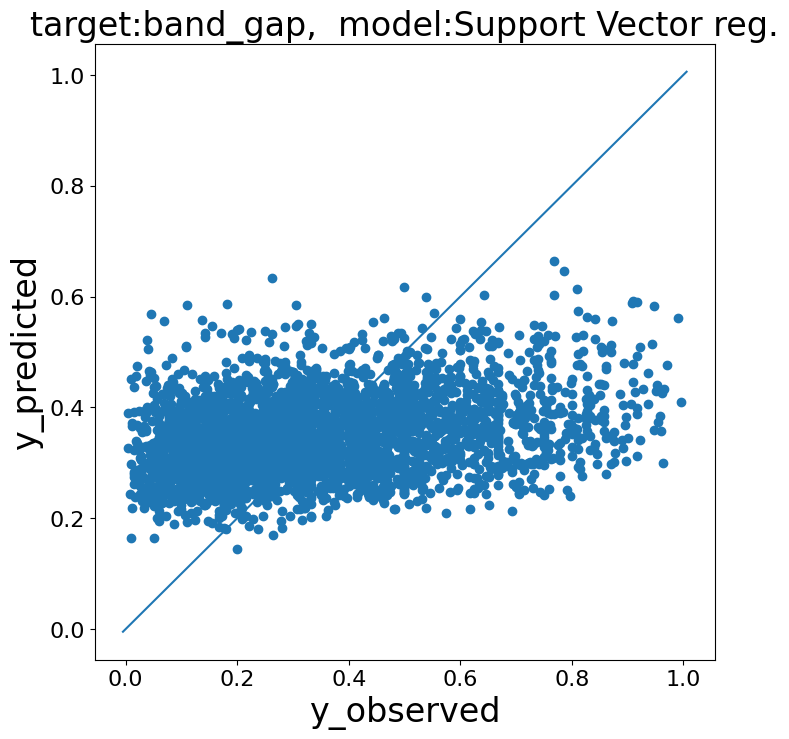

決定係数：0.097
RMSE：0.20


In [182]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [183]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,トリートメント比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.112
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.093
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.716
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.258
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.327
...,...,...,...,...,...,...,...,...,...,...,...,...
3390,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.439
3391,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.153
3392,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0.100
3393,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0.030


In [205]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

340    0.643
Name: トリートメント比率, dtype: float64

In [206]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [207]:
print(round(_score, 2), float(tmp_df_y))

0.45 0.643


In [208]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 'パーマ比率'のモデル作成

In [209]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', '口コミスコアサロン全平均', '雰囲気の全平均',
       '接客サービスの全平均', '技術・仕上がりの全平均', 'メニュー。料金の全平均', 'カラー比率', 'トリートメント比率',
       'パーマ比率', '縮毛矯正比率'],
      dtype='object')

In [210]:
prediction_column = 'パーマ比率'

In [211]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
_df=_df[_df[prediction_column]!=1.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,パーマ比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.034
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.056
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.072
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.048
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...
2875,福山・尾道,福山駅前・三吉周辺,2,0,35,2,10,34,0,13.0,0.971,0.029
2876,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.098
2877,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.028
2878,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0.500


In [212]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [213]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [214]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

2it [00:00, 14.63it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.0672576
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.0699487
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.0712439
Training until validation scores don't improve for 10 rounds


5it [00:00, 15.60it/s]

Early stopping, best iteration is:
[22]	valid_0's rmse: 0.068314
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.0701208


In [215]:
scores

[0.06725755950183025,
 0.0699486963499718,
 0.0712439052586934,
 0.0683140265049342,
 0.07012082736019735]

In [216]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [217]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.067258,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.069949,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.071244,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.068314,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.070121,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


0.003 0.778 0.775


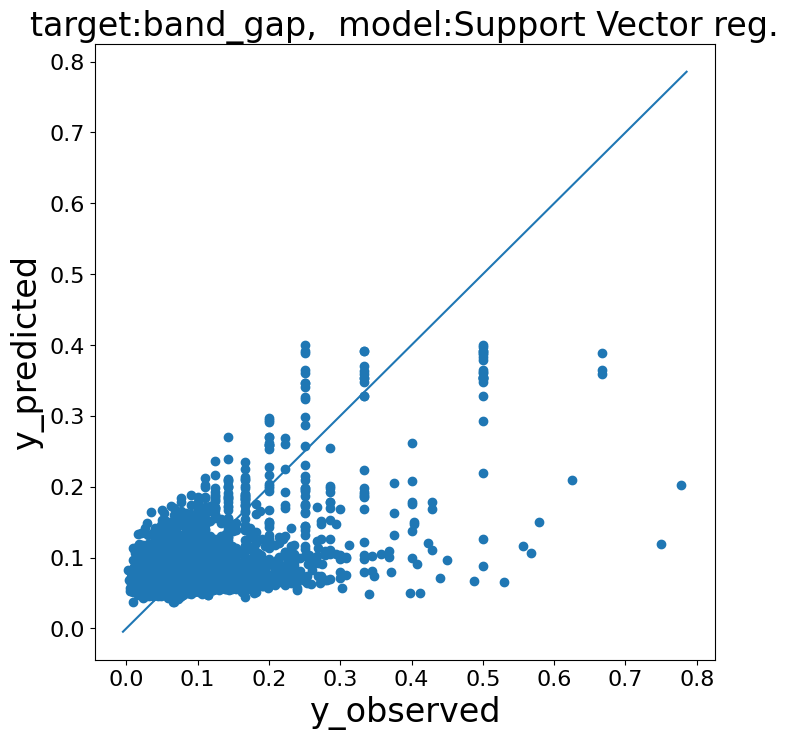

決定係数：0.331
RMSE：0.07


In [218]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [219]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,パーマ比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.034
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.056
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.072
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.048
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...
2875,福山・尾道,福山駅前・三吉周辺,2,0,35,2,10,34,0,13.0,0.971,0.029
2876,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.098
2877,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.028
2878,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0.500


In [228]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

2358    0.125
Name: パーマ比率, dtype: float64

In [229]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [230]:
print(round(_score, 2), float(tmp_df_y))

0.08 0.125


In [231]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# '縮毛矯正比率'のモデル作成

In [232]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', '口コミスコアサロン全平均', '雰囲気の全平均',
       '接客サービスの全平均', '技術・仕上がりの全平均', 'メニュー。料金の全平均', 'カラー比率', 'トリートメント比率',
       'パーマ比率', '縮毛矯正比率'],
      dtype='object')

In [247]:
prediction_column = '縮毛矯正比率'

In [248]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
_df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
_df=_df[_df[prediction_column]!=1.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,縮毛矯正比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.045
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.193
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.125
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.145
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.127
...,...,...,...,...,...,...,...,...,...,...,...,...
2727,福山・尾道,福山駅前・三吉周辺,6,1731,866,5,44,40,147,5.0,0.997,0.103
2728,福山・尾道,福山駅前・三吉周辺,1,0,23,1,10,32,4,15.0,1.000,0.045
2729,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.024
2730,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.153


In [249]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [250]:
lgbm_param = {
    "n_estimators": 10000,
    "max_depth": 60,
    "num_leaves": 100,
    "random_state": 0,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'regression',
    'metric': 'rmse',
    # 'min_data_in_leaf':3
}

In [251]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
CSK = ContinuousStratifiedKFold(n_split=5, shuffle=True, random_state=0)

models = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
scores = []

for train_index, valid_index in tqdm(CSK.split(X=_df_X, reference=_df_y, bins=10)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_train, y_train, 
         eval_metric='rmse',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])
    
    models.append(model)
    scores.append(score)

3it [00:00, 13.59it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.093543
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.098989
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.0934401


5it [00:00, 13.47it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.0967537
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.0931698


In [252]:
scores

[0.09354303033009187,
 0.09898899184568476,
 0.09344008160977493,
 0.09675370887639578,
 0.09316980470045028]

In [253]:
models

[LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0),
 LGBMRegressor(categorical_feature=['県', 'エリア'], max_depth=60, metric='rmse',
               n_estimators=10000, num_leaves=100, objective='regression',
               random_state=0)]

In [254]:
# 結果をまとめておく
import datetime
df_result = pd.concat([pd.DataFrame(scores), pd.DataFrame(models).iloc[:,0]], axis=1)
df_result.columns = ["rmse", "model"]
# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,rmse,model
0,0.093543,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
1,0.098989,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
2,0.093440,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
3,0.096754,"LGBMRegressor(categorical_feature=['県', 'エリア']..."
4,0.093170,"LGBMRegressor(categorical_feature=['県', 'エリア']..."


0.001 0.938 0.9369999999999999


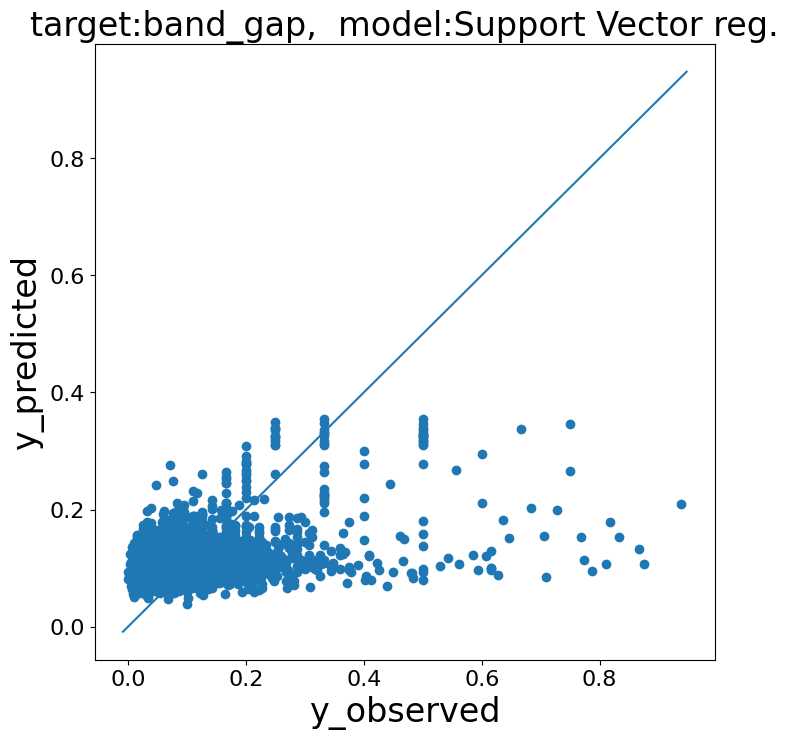

決定係数：0.162
RMSE：0.10


In [255]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [256]:
_df

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,縮毛矯正比率
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0.045
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0.193
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0.125
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0.145
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0.127
...,...,...,...,...,...,...,...,...,...,...,...,...
2727,福山・尾道,福山駅前・三吉周辺,6,1731,866,5,44,40,147,5.0,0.997,0.103
2728,福山・尾道,福山駅前・三吉周辺,1,0,23,1,10,32,4,15.0,1.000,0.045
2729,福山・尾道,福山駅前・三吉周辺,2,0,42,1,10,25,4,NaN,0.000,0.024
2730,福山・尾道,福山駅前・三吉周辺,8,0,73,4,0,27,0,NaN,1.000,0.153


In [269]:
import random
tmp_index = random.randint(1, 3500)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

2184    0.053
Name: 縮毛矯正比率, dtype: float64

In [270]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
_score=np.mean(_scores)

In [271]:
print(round(_score, 2), float(tmp_df_y))

0.08 0.053


In [272]:
import pickle
with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/menu_ratio_and_review_points/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)